In [38]:
%load_ext autoreload
%autoreload 2

In [37]:
#Selection of version of tensorflow in colab
#%tensorflow_version 1.x

#imports the required libraries
import keras
import tensorflow as tf
from tensorflow.compat.v1  import  roll
import numpy as np
import cv2
from keras import optimizers
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Add, Lambda, Subtract,Layer,Cropping2D,Reshape
from keras.optimizers import *
from math import pi as pi
from scipy import signal
from keras import backend as K
from math import pi as pi
import matplotlib.pyplot as plt
import math
import os

from scipy.ndimage import label, generate_binary_structure
from scipy.io import loadmat

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

!pip install LightPipes


print(tf.__version__)
print(keras.__version__)

from keras.constraints import Constraint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from natsort import natsorted
import glob
import imageio
from skimage.io         import imread, imsave
from skimage.measure    import regionprops
from skimage.io         import imsave


2.5.0
2.5.0


In [40]:
# Get the relative path of the root path of the project, i.e. "projet_cassioppee"
NOTEBOOK_DIR = os.getcwd()
ROOT = os.path.dirname(NOTEBOOK_DIR)
print(ROOT)

/Users/roberthajjar/Documents/projet_cassioppee


In [22]:
# Functions

# This function reads a txt file that has the led positions and puts the values into an array
def spiral_kxky(filename, ledNum):
    kxky = [[], []]
    with open(filename, 'r') as file:
        for line in file:
            for j, value in enumerate(line.split(",")):
                kxky[j].append(np.float(value))
    kxky = np.asarray(kxky)
    kxky = kxky.T
    return kxky[:ledNum, :]

# This function shows the result of the neural network result, does the Fourier 
# inverse transform from the weights of the complex object and thus as a result
# has the reconstructed image in phase and intensity

def show_result(model, show=0, noShow=10,size=10):
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))
    
    c_complex = c_real + 1j * c_imag
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    
    if show:
        plt.figure(figsize=(size,size))
        plt.subplot(233),plt.imshow(np.log(c_abs[noShow:imSize-noShow, noShow:imSize-noShow]+1), cmap='gray'),plt.title('recover (abs)')
        ax = plt.subplot(232)
        plot = plt.imshow(im_phase[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray')
        divider = make_axes_locatable(ax)
        plt.title('recover (phase)')
        cax = divider.append_axes("right", size="5%", pad=0.02)
        plt.colorbar(plot,cax=cax)
        plt.subplot(231),plt.imshow(im_spatial[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover FT')
        plt.show()
        plt.show()
        
    return c_complex

# This function creates a custom layer in the neural network 
class MyLayer( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=True)

        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        a = tf.keras.backend.reshape(x, shape=(-1,imSize,imSize,1))
        return tf.multiply(a,self.kernel)

    def compute_output_shape(self, input_shape):
        return (self.output_dims)

# This function creates a custom layer in the neural network 
# which takes only the led position that is being used in the training example 
class take_one( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(take_one, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=False)

        super(take_one, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        b = tf.keras.backend.reshape(x, shape=(1,1))
        a = tf.keras.backend.cast(b, dtype='int32')
        return a[:,0]*1

    def compute_output_shape(self, input_shape):
        return (self.output_dims)

# This function limits the weight value between a minimum and maximum value 
class Between(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value =  min_value
        self.max_value = max_value

    def __call__(self, w):        
        return K.clip(w, self.min_value, self.max_value)

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}

# This function is a custom neural network layer that does the linear matching between inputs and weights
class ConvexCombination(Layer):
    def __init__(self, **kwargs):
        super(ConvexCombination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(10,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(ConvexCombination, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        h1,h2,h3,h4,h5,h6,h7,h8,h9,h10 = x
        a= self.lambd2[0,0]
        b= self.lambd2[1,0]
        c= self.lambd2[2,0]
        d= self.lambd2[3,0]
        e= self.lambd2[4,0]
        f= self.lambd2[5,0]
        g= self.lambd2[6,0]
        h= self.lambd2[7,0]
        i= self.lambd2[8,0]
        j= self.lambd2[9,0]
        # k= self.lambd2[10,0]
        # l= self.lambd2[11,0]

        new_ctf = a*h1 + b*h2 +  c*h3 + d*h4 + e*h5 + f*h6 + g*h7 + h*h8+i*h9 +j*h10#+ k*h11 +l*h12
        return new_ctf

    def compute_output_shape(self, input_shape):
        return input_shape[0]

# try to make a custom layer to optimize the LED positions
class pos_cal(Layer):
    def __init__(self, **kwargs):
        super(pos_cal, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=(1,1),  # Adding one dimension for broadcasting
                                     initializer='ones',  # Try also 'ones' and 'uniform'
                                     trainable=True,constraint =Between(-1.,1.) )
        super(pos_cal, self).build(input_shape)

    def call(self, x):
        # x is a list of two tensors with shape=(batch_size, H, T)
        a= self.lambd2[0,0]
        new_pos = x+a
        return new_pos

    def compute_output_shape(self, input_shape):
        return input_shape

        
def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [23]:
# set microscope and image parameters
index_downSample = 2 # downsample: index_downSample=4
wlength = 0.620*1e-6
NA = 0.75
k0 = 2 * pi / wlength
magnif = 20
spsize = (3.45*1e-6)/magnif
psize = spsize/index_downSample
crop = 84
imSize = int(crop*index_downSample)
imCenter = int(imSize / 2)
arraysize = 5.97
NAstep = 0.05
dz = 21

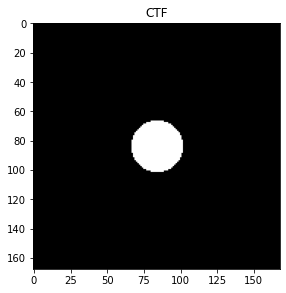

17.528225806451612


In [24]:
# Generate CTF
dkxy = 2*pi/(psize*imSize)
cutoffFrequency = (NA * k0 / dkxy)
center = [imCenter, imCenter]
kYY, kXX = np.ogrid[:imSize, :imSize]
CTF = np.sqrt((kXX - center[0]) ** 2 + (kYY - center[1]) ** 2) <= cutoffFrequency
CTF = CTF.astype(float)

# Show CTF
plt.figure(figsize=(15,15))
plt.xticks(np.arange(0,crop,20))
plt.subplot(1, 3, 3),plt.imshow(CTF[:,:], cmap='gray'),plt.title('CTF')
plt.show()

print(cutoffFrequency)

/Users/roberthajjar/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


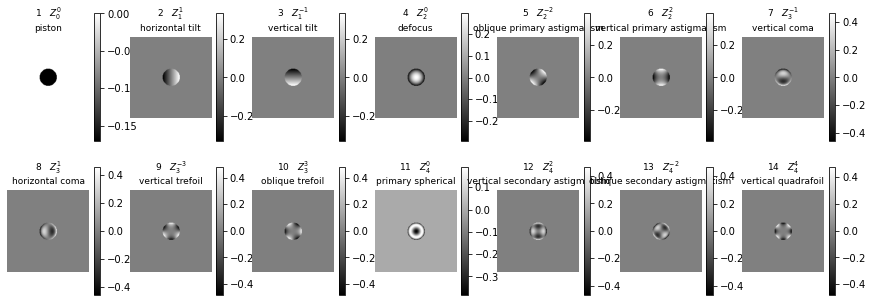

In [41]:
# Import the library and create the Zernike polynomials to be used in the neural network  
from LightPipes import *
import matplotlib.pyplot as plt
import math

wavelength=wlength
cutoffFrequency = (NA * k0 / dkxy)

size=cutoffFrequency
N=imSize
A=wavelength/(N/2*math.pi)

poly = np.ndarray([21,imSize,imSize],dtype=np.float128)

plt.figure(figsize=(15,8)) 
for Noll in range (1,15):
    (nz,mz)=noll_to_zern(Noll)
    S=ZernikeName(Noll)
    F=Begin(N,psize,N)
    F=Zernike(nz,mz,size,A,F)
    F=CircAperture(size,0,0,F)
    Phi=Phase(F)
    Z = Phi
    poly[Noll-1] = Z
    
    # ax1 = plt.subplot(3,7,Noll)
    # plot = plt.imshow(np.real(Z), cmap='gray')
    # plt.colorbar(plot,ax=ax1)
    # s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    # plt.title(s, fontsize=9);plt.axis('off')

    ax1 = plt.subplot(3,7,Noll)
    plot = plt.imshow(poly[Noll-1], cmap='gray')
    plt.colorbar(plot,ax=ax1)
    s=repr(Noll) + '  ' + ' $Z^{'+repr(mz)+'}_{'+repr(nz)+'}$' + '\n' + S
    plt.title(s, fontsize=9);plt.axis('off')
plt.show()


In [26]:
# Remove unnecessary variables

del Z,Phi,S,F

z1_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z2_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z3_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z4_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z5_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z6_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z7_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z8_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z9_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF
z10_input = np.ndarray((int(arraysize ** 2), imSize*imSize, 1),dtype=np.float32) # input CTF

for i in range(int(arraysize ** 2)):
    z1_input[i, :, 0]  = np.reshape(poly[0],(imSize*imSize))
    z2_input[i, :, 0]  = np.reshape(poly[1],(imSize*imSize))
    z3_input[i, :, 0]  = np.reshape(poly[2],(imSize*imSize))
    z4_input[i, :, 0]  = np.reshape(poly[3],(imSize*imSize))
    z5_input[i, :, 0]  = np.reshape(poly[4],(imSize*imSize))
    z6_input[i, :, 0]  = np.reshape(poly[5],(imSize*imSize)) 
    z7_input[i, :, 0]  = np.reshape(poly[6],(imSize*imSize)) 
    z8_input[i, :, 0]  = np.reshape(poly[7],(imSize*imSize)) 
    z9_input[i, :, 0]  = np.reshape(poly[8],(imSize*imSize)) 
    z10_input[i, :, 0]  = np.reshape(poly[9],(imSize*imSize))
del poly

In [27]:
# Creates the neural network 
def create_model():
  center = imSize/2

  # Initializes input layers 
  input_all = Input((imSize*imSize+2, 1),dtype='complex64', name='input_all')  # CTF input + led positions
  input_measurement = Input((crop, crop, 1), name='input_measurement')  # low-resolution images
  nule = Input((imSize,imSize, 1),dtype='float32', name='input_nule')  # CTF tf.ones(tf.shape(input_CTF), tf.float32)

  hx = int(center-crop/2)
  hy = int(center +crop/2)

  # Separates the input_all layer into CTF and led positions
  input_CTF = Lambda(lambda x: x[:,:imSize*imSize,:],name='input_CTF')(input_all)
  input_kx = Lambda(lambda x:  tf.real(x[:,imSize*imSize:imSize*imSize+1,:]),name='input_kx')(input_all)
  input_ky = Lambda(lambda x: tf.real(x[:,imSize*imSize+1:imSize*imSize+2,:]),name='input_ky')(input_all)

  # Initializes the input layers for each Zernike polynomial
  z1 = Input((imSize*imSize, 1),dtype='float', name='z1')  # CTF
  z2 = Input((imSize*imSize, 1),dtype='float', name='z2')  # CTF
  z3 = Input((imSize*imSize, 1),dtype='float', name='z3')  # CTF
  z4 = Input((imSize*imSize, 1),dtype='float', name='z4')  # CTF
  z5 = Input((imSize*imSize, 1),dtype='float', name='z5')  # CTF
  z6 = Input((imSize*imSize, 1),dtype='float', name='z6')  # CTF
  z7 = Input((imSize*imSize, 1),dtype='float', name='z7')  # CTF
  z8 = Input((imSize*imSize, 1),dtype='float', name='z8')  # CTF
  z9 = Input((imSize*imSize, 1),dtype='float', name='z9')  # CTF
  z10 = Input((imSize*imSize, 1),dtype='float', name='z10')  # CTF
  z11 = Input((imSize*imSize, 1),dtype='float', name='z11')  # CTF
  z12 = Input((imSize*imSize, 1),dtype='float', name='z12')  # CTF

  # Selects only the led position of the example that is currently running in the neural network 
  kx_i = take_one((1,),input_shape = (1,1))(input_kx)
  ky_i = take_one((1,),input_shape = (1,1))(input_ky)

  # define O (FT)
  O_FTr = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTr')
  O_FTi = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTi')

  # define P - Pupil 
  P_r = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_r')
  P_i = MyLayer((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_i')

  # Divides the CTF into real and imaginary parts
  CTFr = Lambda(lambda x: tf.real(x))(input_CTF)
  CTFi = Lambda(lambda x: tf.imag(x))(input_CTF)

  # Linear combination of Zernike polynomials: 
  Comb = ConvexCombination(name='inter_z1')([z1,z2,z3,z4,z5,z6,z7,z8,z9,z10])

  # Defines the pupil as a combination of the Zernike polynomials
  Pupil = Lambda(lambda x: tf.exp(1j*tf.cast(x[0],tf.complex64))*x[1],name='Pupil')([Comb,input_CTF])

  # Divides the Pupil into real and imaginary parts
  Pupil_r = Lambda(lambda x: tf.real(x))(Pupil)
  Pupil_i = Lambda(lambda x: tf.imag(x))(Pupil)

  # P*Pupil
  P_cr = P_r(Pupil_r)
  P_ci = P_i(Pupil_i)

  # Multiplies the complex object by a null image
  Or = O_FTr(nule)
  Oi = O_FTi(nule)

  # Moves the complex object according to the led positions 
  Or_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Or')([Or,kx_i,ky_i])  
  Oi_d =  Lambda(lambda x: roll(x[0],shift=[x[1][0],x[2][0]],axis=[1,2]),name='Roll_Oi')([Oi,kx_i,ky_i])

  # Pupil Multiplication with the Complex Object
  CrOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Or_d])
  CiOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Oi_d])
  CrOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Oi_d])
  CiOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Or_d])

  # Cuts the generated result according to index down Sample
  CrOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOr')(CrOr_c)
  CiOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOi')(CiOi_c)
  CrOi = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CrOi')(CrOi_c)
  CiOr = Lambda(lambda x: tf.image.central_crop(x, 1/index_downSample ),name='Crop_CiOr')(CiOr_c)

  # generate low resolution image (FT)
  lowFT_r = Subtract(name='lowFT_r')([CrOr, CiOi])
  lowFT_i = Add(name='lowFT_i')([CrOi, CiOr])

  lowFT = Lambda(lambda x: tf.cast(x[0], tf.complex64) + 1j * tf.cast(x[1], tf.complex64),name='lowFT')([lowFT_r, lowFT_i])
  # do ifft
  im_iFT = Lambda(lambda x: tf.ifft3d(tf.manip.roll(tf.cast(x, tf.complex64),[int(imSize/2), int(imSize/2)], axis=[0, 1])),name='low_iFT')(lowFT)

  image = Lambda(lambda x: tf.abs(x))(im_iFT)

  # keep angle, and use sqrt(I) to change the amplitude
  iFT_angle = Lambda(lambda x: tf.angle(tf.cast(x, tf.complex64)),name='low_iFT_angle')(im_iFT)

  sqrtI = Lambda(lambda x: tf.sqrt(x),name='input_amp')(input_measurement)

  output = Lambda(lambda x: tf.multiply(tf.cast(tf.divide(tf.reduce_sum(x[0]),tf.reduce_sum(x[1])), tf.float32),x[2]),output_shape=(crop,crop,1),name='out')([sqrtI, image,image])

  model = Model(inputs=[input_all,input_measurement,nule,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10], outputs=[output])
  #model.summary()

  return model

  #keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)




In [28]:
# Reads the positions of the leds that have been estimated and placed in a txt document
path_pos_led = os.path.join(ROOT, 'data/positions_des_leds/pos_all_2.txt')
kakr = spiral_kxky(path_pos_led,int( arraysize ** 2)) # load kx, ky here
#print('kxky shape:',kakr.shape)

kx_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement
ky_i = np.ndarray((int(arraysize ** 2),1,1),dtype=np.float32) # input measurement

# The following part makes optimizations of the positions 
# from the genetic algorithm, it can be removed if you want 
# to work only with the original estimation 

kakr[1,0] = kakr[1,0] +14.76734925
kakr[1,1] = kakr[1,1] +	0.59890099

kakr[2,0] = kakr[2,0] +14.89285647
kakr[2,1] = kakr[2,1] +0.92978567

kakr[3,0] = kakr[3,0] + 14.10572814 
kakr[3,1] = kakr[3,1] - 0.05350908

kakr[4,0] = kakr[4,0] + 14.70121004
kakr[4,1] = kakr[4,1] -0.96501889

kakr[5,0] = kakr[5,0] +14.02508033
kakr[5,1] = kakr[5,1] + 0.82702106

kakr[6,0] = kakr[6,0] + 14.97020396
kakr[6,1] = kakr[6,1] -  0.0542885

kakr[7,0] = kakr[7,0] -14.96710334  
kakr[7,1] = kakr[7,1] -0.77540696

kakr[9,0] = kakr[9,0] + 3.36549871
kakr[9,1] = kakr[9,1]  -0.40575659

kakr[11,0] = kakr[11,0] + 6.61696441 
kakr[11,1] = kakr[11,1] -0.65608742

kakr[12,0] = kakr[12,0] + 6.93462461 
kakr[12,1] = kakr[12,1] + 0.29434819

kakr[13,0] = kakr[13,0] + 5.15290666 
kakr[13,1] = kakr[13,1] + 0.62740655

kakr[14,0] = kakr[14,0] + 4.9515296
kakr[14,1] = kakr[14,1] + 0.46726247

kakr[15,0] = kakr[15,0] + 0.88872929 
kakr[15,1] = kakr[15,1] -0.00710684

kakr[16,0] = kakr[16,0] + 3.60385903 
kakr[16,1] = kakr[16,1] + 0.46693824

kakr[18,0] = kakr[18,0] -14.55634447  
kakr[18,1] = kakr[18,1] +  0.74065819

# It transforms the led positions that are in x,y into kx and ky. 
for i in range(35):
  kx_i[i,0,0] = (kakr[i,0]*(crop/500))*np.cos(kakr[i,1])
  ky_i[i,0,0] = (kakr[i,0]*(crop/500))*np.sin(kakr[i,1])
  print(kakr[i])

[0. 0.]
[64.26541138  3.22134753]
[64.3909186  -1.49266087]
[64.10572814 -1.42430545]
[64.19927217 -1.23416503]
[63.52314246  1.3461672 ]
[64.97020396  1.51650787]
[80.37730279  2.19456751]
[95.99999237  3.54159274]
[98.70990484 -2.52573096]
[95.34440613 -1.59241457]
[104.61696441  -1.72688374]
[107.27902311  -0.27982981]
[106.99731279   0.55578824]
[106.95153723   0.91726246]
[102.23313542   0.91451144]
[100.94825753   1.91611627]
[101.           1.93079639]
[84.78806166  3.18307295]
[92.92370605  3.10006309]
[93.         -2.84159255]
[92.         -2.39159255]
[91.92371368 -2.00006323]
[91.37973022 -1.60619431]
[91.92369843 -1.21232574]
[92.         -0.82079642]
[91.92370605 -0.4292668 ]
[ 9.13797302e+01 -3.53981733e-02]
[91.92369843  0.35847044]
[92.          0.75000001]
[91.92371368  1.14152957]
[91.92369843  1.47926676]
[92.          1.87079632]
[91.92369843  2.26232576]
[91.37973022  2.65619445]


In [29]:
# Function that removes the background from the image according to the segmentation that has already been done
def extract_imagette(image, labeled,raw, coords_para, coords_distrac,cells_mean=60, size1=71, size2=71, 
                     travel_output=os.getcwd()+"_output/", tophat=False, zoro=False,mask=False):
  
    for region in regionprops(labeled):

        image_sortie=np.zeros([size1,size2], dtype='uint8')

        if region.equivalent_diameter>cells_mean*2/3:

            coords = region.coords
            
            #imagette image
            image_sortie[coords[:,0],coords[:,1]]=\
            image[coords[:,0],coords[:,1]]

            imsave(travel_output, image_sortie)


In [39]:
import time
original =np.ndarray((35, crop, crop))

path_log = os.path.join(ROOT, 'data/outputs/save_segmentation')
login = path_log
#login = "/content/drive/My Drive/Stage/code_test_nicolas/data/save_cell/out"

print(os.listdir(login))

# Select which cell samples you will work with, knowing that for patient CAT01 we have 10 samples in total 
list_log = os.listdir(login)[8:]

for log in list_log:
    print(log)
    travel = login+'/'+log+'/'

    infected = []
    healthy =[]

    path_output = os.path.join(ROOT, 'data/outputs/fpm_84/CAT01/' + log+'/')
    travel_output = path_output
    print(travel_output)

    if not os.path.exists(travel_output):
        os.makedirs(travel_output)

    for arch in os.listdir(travel):
        if 'infected' in arch:
            infected.append(arch)
        if 'healthy' in arch:
            healthy.append(arch)

    print(len(healthy))

    count = 0 
    # Cut off the number of cells you are going to make the FPM
    healthy = healthy[1300:]
    print(len(healthy))

    # If you want to do with infected cells change the ch to ch=infected[i] (line 38) and also the for to "for i in range(len(infected)) (line 37)"
    for i in range(len(healthy)):
        ch = healthy[i]
        start = time.time()
        tf.keras.backend.clear_session()
        title1 ='_' + ch +'_phase.png'
        title2 ='_' + ch +'_inten.png'
        i = 0
        celule = travel + ch +'/'
        original =np.ndarray((35, crop, crop))

        for image_path in natsorted(glob.glob(celule+'*.png')):
            image = imageio.imread(image_path)
            if 'mask' not in image_path:
                original[i] = cv2.fastNlMeansDenoising(image,None,3,7,15)  
                i = i+1
            else:
                mask = image
    divs = original.copy()
    
    cell = divs

    # Generate CTFs
    imgs_train_input1 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.complex64) # input CTF
    imgs_train_input2 = np.ndarray((int(arraysize ** 2), crop, crop, 1)) # input CTF
    imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF

    for i in range(int(arraysize ** 2)):
        imgs_train_input2[i, :, :, 0] = cell[i]
        imgs_train_input1[i, :, :, 0] = CTF.astype(np.complex64)
        imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)

    imgs_train_input3 = np.reshape(imgs_train_input1,(int(arraysize ** 2),imSize* imSize, 1))

    imgs_train_input3 = np.concatenate((imgs_train_input3,kx_i,ky_i),axis=1)

    model = create_model()

    weight_or = np.ndarray((1, imSize, imSize, 1))
    weight_oi = np.ndarray((1, imSize, imSize, 1))

    weight_pr = np.ndarray((1, imSize, imSize, 1))
    weight_pi = np.ndarray((1, imSize, imSize, 1))

    weight_z1 = np.zeros((10, 1))

    imgs_test_predict = np.sqrt(imgs_train_input2)

    # set low res image FT as the initial weight
    imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt( rescale(imgs_train_input2[0, :, :, 0], index_downSample,anti_aliasing=False)))).astype(np.complex128)
    weight_or[0, :, :, 0] = np.real(imlowFT1)
    weight_oi[0, :, :, 0] = np.imag(imlowFT1)

    model.get_layer('O_FTr').set_weights(weight_or)
    model.get_layer('O_FTi').set_weights(weight_oi)
    model.get_layer('inter_z1').set_weights([weight_z1])

    model.get_layer('P_r').trainable = False
    model.get_layer('P_i').trainable = False
    model.get_layer('O_FTr').trainable = False
    model.get_layer('O_FTi').trainable = False
    model.get_layer('inter_z1').trainable = True

    # Trains the neural net only the layer of Zernike polynomials 
    adam = Adagrad(learning_rate=0.01)
    model.compile(loss='mean_absolute_error', optimizer=adam)
    history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=10, verbose=0, shuffle=False)


    model.get_layer('O_FTr').trainable = True
    model.get_layer('O_FTi').trainable = True
    model.get_layer('inter_z1').trainable = False

    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

    weight_or[0, :, :, 0] = c_real
    weight_oi[0, :, :, 0] = c_imag 

    model.get_layer('O_FTr').set_weights(weight_or)
    model.get_layer('O_FTi').set_weights(weight_oi)

    # Train the complex object
    adam = RMSprop(learning_rate=10)
    model.compile(loss="mean_absolute_error", optimizer=adam)
    history = model.fit([imgs_train_input3, imgs_train_input2,imgs_train_input4,z1_input,z2_input,z3_input,z4_input,z5_input,z6_input,z7_input,z8_input,z9_input,z10_input],imgs_test_predict, batch_size=1, epochs=10, verbose=0, shuffle=False)

    # Takes the object and performs the inverse Fourier transform to get the intensity and phase image and save it to file
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), 0].reshape((crop, crop))
    c_imag = w_conv_Oi_array[0, int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), int(imSize/2)-int(crop/2):int(imSize/2)+int(crop/2), 0].reshape((crop, crop))

    c_complex = c_real + 1j * c_imag
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))

    classe=regionprops(mask)

    image = im_spatial
    #normalise image
    if image.dtype!='uint8':
        img_cr=(image -image.min())/(image.max()-image.min())
        image=img_cr*255
        del img_cr
        image=np.array(image, dtype='uint8')
    extract_imagette(image, mask, coords_para=False, coords_distrac=False,raw=i,cells_mean=60, size1=crop, size2=crop,  travel_output=travel_output+title2,mask=False)


    image = im_phase
    #normalise image
    if image.dtype!='uint8':
        img_cr=(image -image.min())/(image.max()-image.min())
        image=img_cr*255
        del img_cr
        image=np.array(image, dtype='uint8')
    extract_imagette(image, mask, coords_para=False, coords_distrac=False,raw=i,cells_mean=60, size1=crop, size2=crop,  travel_output=travel_output+title1,mask=False)
    end = time.time()
    print(count,end-start)

    count = count+1
    
    del image, imgs_train_input3, imgs_train_input1,imgs_train_input2, model,weight_or,weight_oi,weight_pr,weight_pi,weight_z1,c_imag,c_real,original
    tf.keras.backend.clear_session()
    
    tf.keras.backend.clear_session()

    #plt.figure(figsize=(15,15))
    #plt.xticks(np.arange(0,crop,20))
    #plt.subplot(1, 3, 3),plt.imshow(image, cmap='gray'),plt.title(i)
    #plt.show()

    # Create the path and save the images
    os.makedirs(travel_output)
    imsave(travel_output+title1, im_spatial)
    imsave(travel_output+title2, im_phase)

['9994A323901', '9994A323938', '9994A323947', '9994A323977', '9994A323956', '9994A323968', '9994A323986', '9994A323919', '9994A323910', '9994A323929']
9994A323910
/Users/roberthajjar/Documents/projet_cassioppee/data/outputs/fpm_84/CAT01/9994A323910/
1290
0


AttributeError: module 'tensorflow.compat.v2' has no attribute 'real'

In [33]:
 os.makedirs(travel_output)

NameError: name 'travel_output' is not defined